# PyDMD

## Tutorial 7: Dynamic mode decomposition with control

In this tutorial we will show how extend the dynamic mode decomposition to incorporate the effect of control (this technique has been introduced in the paper [Dynamic mode decomposition with control](https://arxiv.org/abs/1409.6358)).

First of all we import the `DMDc` class from the PyDMD package, we set matplotlib for the notebook and we import numpy and scipy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMDc

Now, we create our dataset: since we want to add the control, the evolution of the complex system can be formally summarized as:
$$
\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k,
$$where the operators $\mathbf{A}$ and $\mathbf{B}$ are the ones we will approximate using DMD. So, for a demostrative purpose, we create the original snapshots by using two random operators.

In [2]:
def create_system(n, m):
    A = scipy.linalg.helmert(n, True)
    B = np.random.rand(n, n)-.5
    x0 = np.array([0.25]*n)
    u = np.random.rand(n, m-1)-.5
    snapshots = [x0]
    for i in range(m-1):
        snapshots.append(A.dot(snapshots[i])+B.dot(u[:, i]))
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': B, 'A': A}

We got 25 snapshots of the evolving system.

In [3]:
s = create_system(25, 10)
print(s['snapshots'].shape)

(25, 10)


Now, we can compute as usually the DMD algorithm on the data: the `fit` method in this version take as arguments the snapshots and the control input (the $\mathbf{B}$ operator can be also passed). In this case, we don't perform any truncation.

In [4]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s['snapshots'], s['u'])

Let's visualize the original system and the reconstructed one: also because the no truncation, the plots are the same!

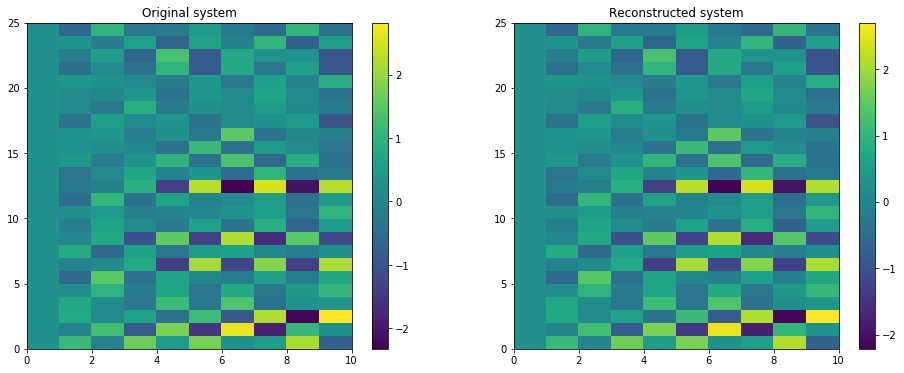

In [5]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(s['snapshots'].real)
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

Well, we built the approximation for $\mathbf{A}$ and for $\mathbf{B}$; we can now test the system with a different control input: differently by the other versions, we can pass as argument of the `reconstructed_data` method the control input we want to test.

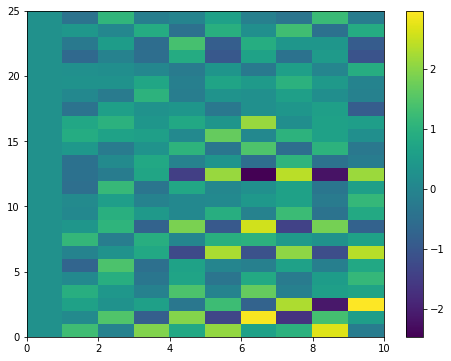

In [6]:
new_u = np.exp(s['u'])

plt.figure(figsize=(8,6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

Finally, we can also use a different timestep for the reconstruction, obviously passing the proper control input (the number of inputs we pass has to be the number of reconstructed snapshots we try to compute, except for the first snapshots). We continue halving the timestep and create a new random input.

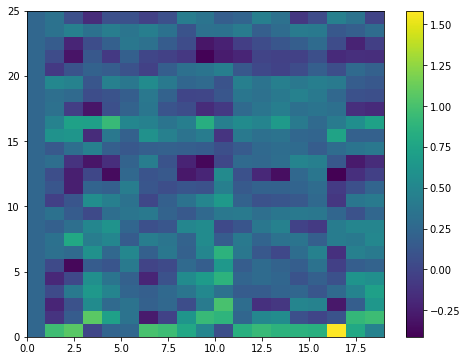

In [7]:
dmdc.dmd_time['dt'] = .5
new_u = np.random.rand(s['u'].shape[0], dmdc.dynamics.shape[1]-1)

plt.figure(figsize=(8,6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()